<a href="https://colab.research.google.com/github/brndiogo/brndiogo-iIoT-Garbage-Management-Monitoring-and-Acknowledgment-System-Review/blob/main/Colab_Teste2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Instala a biblioteca do Kaggle
!pip install kaggle

# 2. Pede para você fazer o upload do seu arquivo kaggle.json
from google.colab import files
print("--- Por favor, faça o upload do seu arquivo kaggle.json ---")
files.upload()

# 3. Configura o arquivo kaggle.json no lugar certo
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 4. Baixa o Dataset "Garbage Classification" (6 classes)
print("\n--- Baixando o dataset 'asdasdasasdas/garbage-classification'... ---")
!kaggle datasets download -d asdasdasasdas/garbage-classification

# 5. Descompacta o dataset
# (Ele cria uma pasta chamada 'Garbage classification' com 6 subpastas)
print("--- Descompactando arquivos... ---")
!unzip -q garbage-classification.zip

print("\n--- PRONTO! O dataset está em /content/Garbage classification/ ---")

--- Por favor, faça o upload do seu arquivo kaggle.json ---


Saving kaggle.json to kaggle.json

--- Baixando o dataset 'asdasdasasdas/garbage-classification'... ---
Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
License(s): copyright-authors
  0% 0.00/82.0M [00:00<?, ?B/s]
100% 82.0M/82.0M [00:00<00:00, 1.84GB/s]
--- Descompactando arquivos... ---

--- PRONTO! O dataset está em /content/Garbage classification/ ---


--- Carregando dataset de TREINO (80%)... ---
Found 2527 files belonging to 1 classes.
Using 2022 files for training.
--- Carregando dataset de VALIDAÇÃO (20%)... ---
Found 2527 files belonging to 1 classes.
Using 505 files for validation.

--- Iniciando Experimento A (RAMPA / STEP DECAY) ---
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 439ms/step - accuracy: 0.8916 - loss: 0.3221 - val_accuracy: 1.0000 - val_loss: 2.5105e-04
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 2.0785e-04 - val_accuracy: 1.0000 - val_loss: 2.2808e-04
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 1.9039e-04 - val_accuracy: 1.0000 - val_loss: 2.0875e-04
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 1.7349e-04 - val_accuracy: 1.0000 - val_loss: 1.8954e-04
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 1.5699e-04 - val_accuracy: 1.0000 - val_l

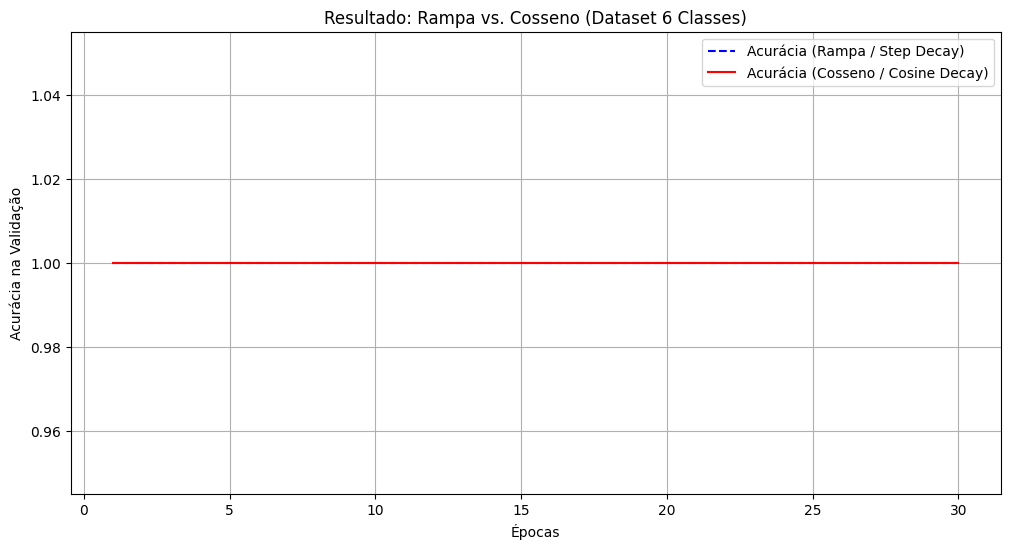

Acurácia final (Rampa):   1.0000
Acurácia final (Cosseno): 1.0000


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# --- 1. Configuração do Experimento (MUDANÇA AQUI) ---
IMG_WIDTH = 128
IMG_HEIGHT = 128
NUM_CLASSES = 6   # MUDANÇA: Agora temos 6 classes
BATCH_SIZE = 32
TOTAL_EPOCHS = 30 # 30 épocas continua sendo um bom teste

# Caminho para os dados que baixamos no Bloco 1
DATA_PATH = 'Garbage classification' # MUDANÇA: O nome da pasta

# --- 2. Carregar os Dados Reais (MUDANÇA GRANDE AQUI) ---
# Este dataset não tem separação de treino/validação, então criamos uma (80/20).

print("--- Carregando dataset de TREINO (80%)... ---")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    label_mode='int',
    validation_split=0.2,  # Define que 20% dos dados serão para validação
    subset='training',     # Define este como o conjunto de TREINO
    seed=123               # Semente para garantir que os dados não se misturem
)

print("--- Carregando dataset de VALIDAÇÃO (20%)... ---")
val_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    label_mode='int',
    validation_split=0.2,  # Mesma separação de 20%
    subset='validation',   # Define este como o conjunto de VALIDAÇÃO
    seed=123               # MESMA semente para garantir que não há sobreposição
)

# Otimização: Pré-carregar dados para a GPU
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Calcula o número de passos de treinamento por época
STEPS_PER_EPOCH = len(train_dataset)


# --- 3. Função para Criar o Modelo (MobileNetV2) ---
# (O código aqui é idêntico ao anterior, mas a camada final
# será automaticamente ajustada para NUM_CLASSES = 6)
def criar_modelo():
    base_modelo = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
        include_top=False,
        weights='imagenet'
    )
    base_modelo.trainable = False

    modelo = tf.keras.Sequential([
        layers.Rescaling(1./255),
        base_modelo,
        layers.GlobalAveragePooling2D(),
        layers.Dense(NUM_CLASSES, activation='softmax') # Automaticamente usará 6 classes
    ])
    return modelo

# --- 4. Experimento A: "Rampa" (Step Decay) ---
print("\n--- Iniciando Experimento A (RAMPA / STEP DECAY) ---")

modelo_rampa = criar_modelo()

lr_schedule_rampa = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[STEPS_PER_EPOCH * 10, STEPS_PER_EPOCH * 20],
    values=[0.001, 0.0005, 0.0001]
)

modelo_rampa.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule_rampa),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_rampa = modelo_rampa.fit(
    train_dataset,
    epochs=TOTAL_EPOCHS,
    validation_data=val_dataset
)


# --- 5. Experimento B: "Cosseno" (Cosine Decay) ---
print("\n--- Iniciando Experimento B (COSSENO / COSINE DECAY) ---")

modelo_cosseno = criar_modelo() # CRÍTICO: Crie um modelo novo!

total_decay_steps = STEPS_PER_EPOCH * TOTAL_EPOCHS
lr_schedule_cosseno = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001,
    decay_steps=total_decay_steps
)

modelo_cosseno.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule_cosseno),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_cosseno = modelo_cosseno.fit(
    train_dataset,
    epochs=TOTAL_EPOCHS,
    validation_data=val_dataset
)


# --- 6. Análise: Plotar os Gráficos ---
print("\n--- Plotando Resultados (A Análise) ---")

acc_rampa = history_rampa.history['val_accuracy']
acc_cosseno = history_cosseno.history['val_accuracy']
epocas = range(1, TOTAL_EPOCHS + 1)

plt.figure(figsize=(12, 6))
plt.plot(epocas, acc_rampa, 'b--', label='Acurácia (Rampa / Step Decay)')
plt.plot(epocas, acc_cosseno, 'r-', label='Acurácia (Cosseno / Cosine Decay)')
plt.title('Resultado: Rampa vs. Cosseno (Dataset 6 Classes)')
plt.xlabel('Épocas')
plt.ylabel('Acurácia na Validação')
plt.legend()
plt.grid(True)
plt.show()

# Comparação final
print(f"Acurácia final (Rampa):   {acc_rampa[-1]:.4f}")
print(f"Acurácia final (Cosseno): {acc_cosseno[-1]:.4f}")

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# --- 1. Configuração do Experimento (MUDANÇA AQUI) ---
IMG_WIDTH = 128
IMG_HEIGHT = 128
NUM_CLASSES = 6
BATCH_SIZE = 32
TOTAL_EPOCHS = 50 # MUDANÇA: Aumentamos de 30 para 50 épocas

DATA_PATH = 'Garbage classification'

# --- 2. Carregar os Dados Reais ---
# (Esta parte é idêntica à anterior)
print("--- Carregando dataset de TREINO (80%)... ---")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    label_mode='int',
    validation_split=0.2,
    subset='training',
    seed=123
)

print("--- Carregando dataset de VALIDAÇÃO (20%)... ---")
val_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=123
)

train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

STEPS_PER_EPOCH = len(train_dataset)


# --- 3. Função para Criar o Modelo (MUDANÇA GRANDE AQUI) ---
def criar_modelo():
    base_modelo = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
        include_top=False,
        # MUDANÇA: 'imagenet' virou None. O modelo começará "burro".
        weights=None
    )
    # MUDANÇA: Como não estamos usando pesos pré-treinados,
    # não precisamos congelar o modelo. Ele precisa treinar.
    # base_modelo.trainable = False  <-- LINHA REMOVIDA

    modelo = tf.keras.Sequential([
        layers.Rescaling(1./255),
        base_modelo,
        layers.GlobalAveragePooling2D(),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return modelo

# --- 4. Experimento A: "Rampa" (Step Decay) ---
print("\n--- Iniciando Experimento A (RAMPA / STEP DECAY) ---")

modelo_rampa = criar_modelo()

# Ajustamos as quedas para 50 épocas (ex: épocas 20 e 40)
lr_schedule_rampa = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[STEPS_PER_EPOCH * 20, STEPS_PER_EPOCH * 40],
    values=[0.001, 0.0005, 0.0001]
)

modelo_rampa.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule_rampa),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_rampa = modelo_rampa.fit(
    train_dataset,
    epochs=TOTAL_EPOCHS,
    validation_data=val_dataset
)


# --- 5. Experimento B: "Cosseno" (Cosine Decay) ---
print("\n--- Iniciando Experimento B (COSSENO / COSINE DECAY) ---")

modelo_cosseno = criar_modelo() # CRÍTICO: Crie um modelo novo!

total_decay_steps = STEPS_PER_EPOCH * TOTAL_EPOCHS
lr_schedule_cosseno = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001,
    decay_steps=total_decay_steps
)

modelo_cosseno.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule_cosseno),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_cosseno = modelo_cosseno.fit(
    train_dataset,
    epochs=TOTAL_EPOCHS,
    validation_data=val_dataset
)


# --- 6. Análise: Plotar os Gráficos ---
# (Esta parte é idêntica à anterior)
print("\n--- Plotando Resultados (A Análise) ---")

acc_rampa = history_rampa.history['val_accuracy']
acc_cosseno = history_cosseno.history['val_accuracy']
epocas = range(1, TOTAL_EPOCHS + 1)

plt.figure(figsize=(12, 6))
plt.plot(epocas, acc_rampa, 'b--', label='Acurácia (Rampa / Step Decay)')
plt.plot(epocas, acc_cosseno, 'r-', label='Acurácia (Cosseno / Cosine Decay)')
plt.title('Resultado: Rampa vs. Cosseno (Treinando do Zero)')
plt.xlabel('Épocas')
plt.ylabel('Acurácia na Validação')
plt.legend()
plt.grid(True)
plt.show()

print(f"Acurácia final (Rampa):   {acc_rampa[-1]:.4f}")
print(f"Acurácia final (Cosseno): {acc_cosseno[-1]:.4f}")

--- Carregando dataset de TREINO (80%)... ---
Found 2527 files belonging to 1 classes.
Using 2022 files for training.
--- Carregando dataset de VALIDAÇÃO (20%)... ---
Found 2527 files belonging to 1 classes.
Using 505 files for validation.

--- Iniciando Experimento A (RAMPA / STEP DECAY) ---
Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 78s 534ms/step - accuracy: 0.9074 - loss: 0.2370 - val_accuracy: 1.0000 - val_loss: 1.3714
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 1.0000 - loss: 2.1569e-05 - val_accuracy: 1.0000 - val_loss: 1.2662
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 1.0000 - loss: 1.9173e-05 - val_accuracy: 1.0000 - val_loss: 1.1491
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 1.0000 - loss: 1.7409e-05 - val_accuracy: 1.0000 - val_loss: 1.0340
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 1.0000 - loss: 1.5876e-05 - val_accuracy: 1.0000 - val_loss: 0.9248
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - 

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# --- 1. Configuração do Experimento (MUDANÇA AQUI) ---
IMG_WIDTH = 128
IMG_HEIGHT = 128
NUM_CLASSES = 6
BATCH_SIZE = 32
TOTAL_EPOCHS = 50 # MUDANÇA: Aumentamos de 30 para 50 épocas

# CORREÇÃO AQUI: Apontamos para a subpasta correta
DATA_PATH = 'Garbage classification/Garbage classification'

# --- 2. Carregar os Dados Reais ---
# (O resto do código não precisa de alterações)
print("--- Carregando dataset de TREINO (80%)... ---")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    label_mode='int',
    validation_split=0.2,
    subset='training',
    seed=123
)

print("--- Carregando dataset de VALIDAÇÃO (20%)... ---")
val_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=123
)

train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

STEPS_PER_EPOCH = len(train_dataset)


# --- 3. Função para Criar o Modelo (MUDANÇA GRANDE AQUI) ---
def criar_modelo():
    base_modelo = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
        include_top=False,
        # MUDANÇA: 'imagenet' virou None. O modelo começará "burro".
        weights=None
    )
    # MUDANÇA: Como não estamos usando pesos pré-treinados,
    # não precisamos congelar o modelo. Ele precisa treinar.
    # base_modelo.trainable = False  <-- LINHA REMOVIDA

    modelo = tf.keras.Sequential([
        layers.Rescaling(1./255),
        base_modelo,
        layers.GlobalAveragePooling2D(),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return modelo

# --- 4. Experimento A: "Rampa" (Step Decay) ---
print("\n--- Iniciando Experimento A (RAMPA / STEP DECAY) ---")

modelo_rampa = criar_modelo()

# Ajustamos as quedas para 50 épocas (ex: épocas 20 e 40)
lr_schedule_rampa = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[STEPS_PER_EPOCH * 20, STEPS_PER_EPOCH * 40],
    values=[0.001, 0.0005, 0.0001]
)

modelo_rampa.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule_rampa),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_rampa = modelo_rampa.fit(
    train_dataset,
    epochs=TOTAL_EPOCHS,
    validation_data=val_dataset
)


# --- 5. Experimento B: "Cosseno" (Cosine Decay) ---
print("\n--- Iniciando Experimento B (COSSENO / COSINE DECAY) ---")

modelo_cosseno = criar_modelo() # CRÍTICO: Crie um modelo novo!

total_decay_steps = STEPS_PER_EPOCH * TOTAL_EPOCHS
lr_schedule_cosseno = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001,
    decay_steps=total_decay_steps
)

modelo_cosseno.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule_cosseno),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_cosseno = modelo_cosseno.fit(
    train_dataset,
    epochs=TOTAL_EPOCHS,
    validation_data=val_dataset
)


# --- 6. Análise: Plotar os Gráficos ---
# (Esta parte é idêntica à anterior)
print("\n--- Plotando Resultados (A Análise) ---")

acc_rampa = history_rampa.history['val_accuracy']
acc_cosseno = history_cosseno.history['val_accuracy']
epocas = range(1, TOTAL_EPOCHS + 1)

plt.figure(figsize=(12, 6))
plt.plot(epocas, acc_rampa, 'b--', label='Acurácia (Rampa / Step Decay)')
plt.plot(epocas, acc_cosseno, 'r-', label='Acurácia (Cosseno / Cosine Decay)')
plt.title('Resultado: Rampa vs. Cosseno (Treinando do Zero)')
plt.xlabel('Épocas')
plt.ylabel('Acurácia na Validação')
plt.legend()
plt.grid(True)
plt.show()

print(f"Acurácia final (Rampa):   {acc_rampa[-1]:.4f}")
print(f"Acurácia final (Cosseno): {acc_cosseno[-1]:.4f}")

--- Carregando dataset de TREINO (80%)... ---
Found 2527 files belonging to 6 classes.
Using 2022 files for training.
--- Carregando dataset de VALIDAÇÃO (20%)... ---
Found 2527 files belonging to 6 classes.
Using 505 files for validation.

--- Iniciando Experimento A (RAMPA / STEP DECAY) ---
Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 71s 479ms/step - accuracy: 0.3193 - loss: 1.7306 - val_accuracy: 0.2040 - val_loss: 1.7851
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.5319 - loss: 1.2849 - val_accuracy: 0.2040 - val_loss: 1.7865
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6022 - loss: 1.0567 - val_accuracy: 0.2040 - val_loss: 1.7857
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6932 - loss: 0.8530 - val_accuracy: 0.1644 - val_loss: 1.7862
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7214 - loss: 0.7567 - val_accuracy: 0.1644 - val_loss: 1.7830
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7114

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# --- 1. Configuração do Experimento ---
IMG_WIDTH = 128
IMG_HEIGHT = 128
NUM_CLASSES = 6
BATCH_SIZE = 32
TOTAL_EPOCHS = 50
DATA_PATH = 'Garbage classification/Garbage classification' # Caminho corrigido

# --- 2. Carregar os Dados Reais ---
# (Esta parte é idêntica à anterior)
print("--- Carregando dataset de TREINO (80%)... ---")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    label_mode='int',
    validation_split=0.2,
    subset='training',
    seed=123
)

print("--- Carregando dataset de VALIDAÇÃO (20%)... ---")
val_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=123
)

train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

STEPS_PER_EPOCH = len(train_dataset)

# --- 3. Função para Criar o Modelo (MUDANÇAS AQUI) ---

# Primeiro, definimos a camada de "Aumento de Dados"
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
])

def criar_modelo():
    base_modelo = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
        include_top=False,
        weights=None # Continuamos treinando do zero
    )

    modelo = tf.keras.Sequential([
        layers.Rescaling(1./255),

        # MUDANÇA: Aplicamos o Aumento de Dados SÓ no treino
        data_augmentation,

        base_modelo,
        layers.GlobalAveragePooling2D(),

        # MUDANÇA: Adicionamos Dropout para regularização
        layers.Dropout(0.4), # "Desliga" 40% dos neurônios

        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return modelo

# --- 4. Experimento A: "Rampa" (Step Decay) ---
print("\n--- Iniciando Experimento A (RAMPA / STEP DECAY) ---")

modelo_rampa = criar_modelo()

lr_schedule_rampa = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[STEPS_PER_EPOCH * 20, STEPS_PER_EPOCH * 40],
    values=[0.001, 0.0005, 0.0001]
)

modelo_rampa.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule_rampa),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# NOTA: O treino agora será mais LENTO para atingir 100%
# (o que é BOM, significa que está aprendendo)
history_rampa = modelo_rampa.fit(
    train_dataset,
    epochs=TOTAL_EPOCHS,
    validation_data=val_dataset
)


# --- 5. Experimento B: "Cosseno" (Cosine Decay) ---
print("\n--- Iniciando Experimento B (COSSENO / COSINE DECAY) ---")

modelo_cosseno = criar_modelo() # CRÍTICO: Crie um modelo novo!

total_decay_steps = STEPS_PER_EPOCH * TOTAL_EPOCHS
lr_schedule_cosseno = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001,
    decay_steps=total_decay_steps
)

modelo_cosseno.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule_cosseno),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_cosseno = modelo_cosseno.fit(
    train_dataset,
    epochs=TOTAL_EPOCHS,
    validation_data=val_dataset
)


# --- 6. Análise: Plotar os Gráficos ---
print("\n--- Plotando Resultados (A Análise) ---")

acc_rampa = history_rampa.history['val_accuracy']
acc_cosseno = history_cosseno.history['val_accuracy']
epocas = range(1, TOTAL_EPOCHS + 1)

plt.figure(figsize=(12, 6))
plt.plot(epocas, acc_rampa, 'b--', label='Acurácia (Rampa / Step Decay)')
plt.plot(epocas, acc_cosseno, 'r-', label='Acurácia (Cosseno / Cosine Decay)')
plt.title('Resultado: Rampa vs. Cosseno (Com Regularização)')
plt.xlabel('Épocas')
plt.ylabel('Acurácia na Validação')
plt.legend()
plt.grid(True)
plt.show()

print(f"Acurácia final (Rampa):   {acc_rampa[-1]:.4f}")
print(f"Acurácia final (Cosseno): {acc_cosseno[-1]:.4f}")

--- Carregando dataset de TREINO (80%)... ---
Found 2527 files belonging to 6 classes.
Using 2022 files for training.
--- Carregando dataset de VALIDAÇÃO (20%)... ---
Found 2527 files belonging to 6 classes.
Using 505 files for validation.

--- Iniciando Experimento A (RAMPA / STEP DECAY) ---
Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - accuracy: 0.3048 - loss: 1.7637 - val_accuracy: 0.2040 - val_loss: 1.7892
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.4354 - loss: 1.4775 - val_accuracy: 0.2040 - val_loss: 1.7767
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.4674 - loss: 1.3718 - val_accuracy: 0.2040 - val_loss: 1.7693
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.5058 - loss: 1.3040 - val_accuracy: 0.2040 - val_loss: 1.7708
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.5389 - loss: 1.2230 - val_accuracy: 0.2040 - val_loss: 1.7886
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0

KeyboardInterrupt: 

--- Carregando dataset de TREINO (80%)... ---
Found 2527 files belonging to 6 classes.
Using 2022 files for training.
--- Carregando dataset de VALIDAÇÃO (20%)... ---
Found 2527 files belonging to 6 classes.
Using 505 files for validation.

--- Iniciando Experimento A (RAMPA / STEP DECAY) ---
Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.3389 - loss: 1.9116 - val_accuracy: 0.5822 - val_loss: 1.1387
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6752 - loss: 0.8818 - val_accuracy: 0.6416 - val_loss: 1.0229
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7507 - loss: 0.7243 - val_accuracy: 0.6693 - val_loss: 1.0749
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7869 - loss: 0.5920 - val_accuracy: 0.6673 - val_loss: 1.0646
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8039 - loss: 0.5161 - val_accuracy: 0.6812 - val_loss: 1.0686
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8382 

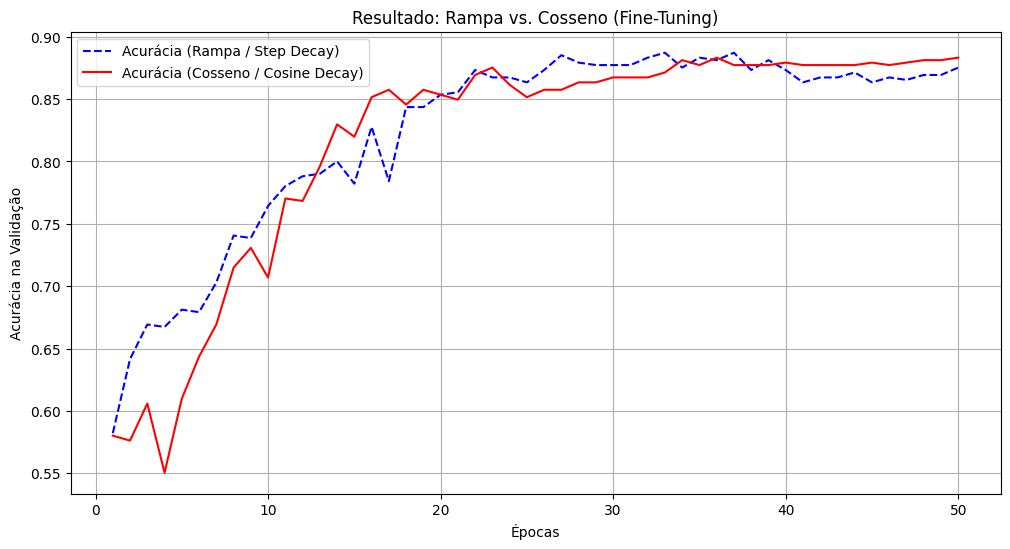

Acurácia final (Rampa):   0.8752
Acurácia final (Cosseno): 0.8832


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# --- 1. Configuração do Experimento ---
IMG_WIDTH = 128
IMG_HEIGHT = 128
NUM_CLASSES = 6
BATCH_SIZE = 32
TOTAL_EPOCHS = 50
DATA_PATH = 'Garbage classification/Garbage classification'

# --- 2. Carregar os Dados Reais ---
# (Esta parte é idêntica à anterior)
print("--- Carregando dataset de TREINO (80%)... ---")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH, image_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE,
    label_mode='int', validation_split=0.2, subset='training', seed=123
)

print("--- Carregando dataset de VALIDAÇÃO (20%)... ---")
val_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH, image_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE,
    label_mode='int', validation_split=0.2, subset='validation', seed=123
)

# Otimização (cache e prefetch)
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

STEPS_PER_EPOCH = len(train_dataset)

# --- 3. Função para Criar o Modelo (MUDANÇA GRANDE AQUI) ---

# Camada de "Aumento de Dados" (essencial para evitar overfitting)
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
])

def criar_modelo():
    # MUDANÇA: Voltamos a usar 'imagenet'
    base_modelo = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
        include_top=False,
        weights='imagenet'
    )

    # MUDANÇA: Permitimos que o modelo base SEJA TREINÁVEL
    base_modelo.trainable = True

    # MUDANÇA: Mas congelamos as camadas iniciais
    # Vamos fazer "fine-tune" (ajustar) apenas das últimas ~54 camadas
    fine_tune_at = 100
    for layer in base_modelo.layers[:fine_tune_at]:
        layer.trainable = False

    modelo = tf.keras.Sequential([
        layers.Rescaling(1./255),
        data_augmentation, # Data augmentation continua
        base_modelo,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4), # Dropout continua
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return modelo

# --- 4. Experimento A: "Rampa" (Step Decay) ---
print("\n--- Iniciando Experimento A (RAMPA / STEP DECAY) ---")

modelo_rampa = criar_modelo()

# MUDANÇA: Taxa de aprendizado INICIAL BEM MENOR (0.0001)
lr_schedule_rampa = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[STEPS_PER_EPOCH * 20, STEPS_PER_EPOCH * 40],
    values=[0.0001, 0.00005, 0.00001] # Valores muito mais baixos
)

modelo_rampa.compile(
    # MUDANÇA: Usamos Adam, mas com a taxa de aprendizado baixa
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule_rampa),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_rampa = modelo_rampa.fit(
    train_dataset,
    epochs=TOTAL_EPOCHS,
    validation_data=val_dataset
)


# --- 5. Experimento B: "Cosseno" (Cosine Decay) ---
print("\n--- Iniciando Experimento B (COSSENO / COSINE DECAY) ---")

modelo_cosseno = criar_modelo() # CRÍTICO: Crie um modelo novo!

total_decay_steps = STEPS_PER_EPOCH * TOTAL_EPOCHS

# MUDANÇA: Taxa de aprendizado INICIAL BEM MENOR (0.0001)
lr_schedule_cosseno = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.0001, # Mesmo valor inicial da Rampa
    decay_steps=total_decay_steps
)

modelo_cosseno.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule_cosseno),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_cosseno = modelo_cosseno.fit(
    train_dataset,
    epochs=TOTAL_EPOCHS,
    validation_data=val_dataset
)


# --- 6. Análise: Plotar os Gráficos ---
print("\n--- Plotando Resultados (A Análise) ---")

acc_rampa = history_rampa.history['val_accuracy']
acc_cosseno = history_cosseno.history['val_accuracy']
epocas = range(1, TOTAL_EPOCHS + 1)

plt.figure(figsize=(12, 6))
plt.plot(epocas, acc_rampa, 'b--', label='Acurácia (Rampa / Step Decay)')
plt.plot(epocas, acc_cosseno, 'r-', label='Acurácia (Cosseno / Cosine Decay)')
plt.title('Resultado: Rampa vs. Cosseno (Fine-Tuning)')
plt.xlabel('Épocas')
plt.ylabel('Acurácia na Validação')
plt.legend()
plt.grid(True)
plt.show()

print(f"Acurácia final (Rampa):   {acc_rampa[-1]:.4f}")
print(f"Acurácia final (Cosseno): {acc_cosseno[-1]:.4f}")